This example is for training a Noise2Void denoising model using RGB images. Images need to be in lossless format (e.g., png or tiff). JPG format is not allowed if you're using the DataGenerator object but you can use skimage or other ibraries to load them. The same approach can be used for grey-scale images, for example SEM or CT images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
# Noise2Void modelini yükleyelim
!pip install n2v

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 38.1 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import n2v
#versiyonları kontrol edelim
print(tf.__version__)
print(n2v.__version__)

2.13.0
0.3.2


In [5]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

**Training Data Preparation**


<p>
For training we can load a bunch of noisy images from a directory. Images can be of different sizes as we will be capturing them as a list, not an array. Of course, each image is an array. We will use the N2V_DataGenerator to extract training X and validation X_val patches.

In [6]:
# DataGenerator, verileri yüklememize ve yamaları çıkarmamıza yardım eder.
datagen = N2V_DataGenerator()

If you have many images stored in a directory, use load_imgs_from_directory method to load them into a list. Images can be of different sizes as we are capturing them into a list, not an array.
<p>
You can also use your favorite way of reading images (e.g., using skimage) sequentially and capturing them into a list that can be used as input to the network.
<p>
Note that the images need to be in float32 format. load_imgs_from_directory method converts images to float32 but if you use your own way of loading images, you need to make sure they are converted to float32.

In [7]:
# Load_imgs_from_directory yöntemini kullanarak görselleri yükleYELİM
# Dizindeki tüm '.png' dosyalarını yüklüyoruz.
# İşlev, görüntülerin bir listesini (numpy dizileri) döndürecektir.
imgs = datagen.load_imgs_from_directory(directory="/content/drive/MyDrive/Colab Notebooks/",
                                        filter='test4.png', dims='XYC')

print(imgs)

print('shape of loaded images: ',imgs[0].shape)

imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)
print('The data type of the first image is: ', imgs[0].dtype)

[array([[[[0.03921569, 0.00784314, 0.19215687],
         [0.03921569, 0.00392157, 0.18039216],
         [0.10980392, 0.06666667, 0.23137255],
         ...,
         [0.3254902 , 0.16470589, 0.        ],
         [0.37254903, 0.21176471, 0.03921569],
         [0.52156866, 0.36078432, 0.1882353 ]],

        [[0.2       , 0.16862746, 0.3529412 ],
         [0.1764706 , 0.14117648, 0.31764707],
         [0.21176471, 0.16862746, 0.33333334],
         ...,
         [0.5294118 , 0.36862746, 0.19607843],
         [0.53333336, 0.37254903, 0.2       ],
         [0.3764706 , 0.21568628, 0.04313726]],

        [[0.09803922, 0.07058824, 0.24313726],
         [0.04313726, 0.00784314, 0.1764706 ],
         [0.04313726, 0.        , 0.16470589],
         ...,
         [0.4862745 , 0.3254902 , 0.15294118],
         [0.44705883, 0.28627452, 0.11372549],
         [0.37254903, 0.21176471, 0.03921569]],

        ...,

        [[0.10980392, 0.10980392, 0.20392157],
         [0.16078432, 0.16078432, 0.25490198

In [8]:
print(len(imgs))
print(imgs[0].shape)
print(imgs[0].dtype)

1
(1, 750, 500, 3)
float32


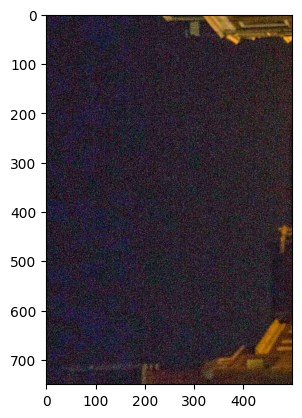

In [9]:
plt.figure()
plt.imshow(imgs[0][0,:,:,:])
plt.show()

In [10]:
patch_size = 64

In [11]:
# Yamalar tüm görüntülerden çıkarılır ve tek bir numpy dizisinde birleştirilir
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)


Generated patches: (616, 64, 64, 3)


In [12]:
# Yamalar çakışmayacak şekilde oluşturulur.
# Çakışmayan yamalar, bunları bir eğitim ve doğrulama kümesine ayırmamıza olanak tanır.
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [13]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

(492, 64, 64, 3)
float32
(124, 64, 64, 3)


In [14]:
datagen.generate_patches_from_list?

In [16]:

train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=20, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

vars(config)

{'means': ['0.1692536', '0.13443866', '0.17855743'],
 'stds': ['0.09307103', '0.07687163', '0.06642934'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 15,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [17]:

model_name = 'n2v_2D_stars'

basedir = 'models'

model = N2V(config, model_name, basedir=basedir)

<h2>Training</h2><p>


In [18]:

history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 124/124 [00:00<00:00, 549.87it/s]


Epoch 1/20
 6/15 [===========>..................] - ETA: 0s - loss: 1.5186 - n2v_mse: 1.5186 - n2v_abs: 0.9406

15/15 [==============================] - 33s 265ms/step - loss: 1.0081 - n2v_mse: 1.0081 - n2v_abs: 0.7463 - val_loss: 0.7716 - val_n2v_mse: 0.7709 - val_n2v_abs: 0.6924 - lr: 4.0000e-04
Epoch 2/20
15/15 [==============================] - 2s 142ms/step - loss: 0.3244 - n2v_mse: 0.3244 - n2v_abs: 0.4110 - val_loss: 0.7390 - val_n2v_mse: 0.7384 - val_n2v_abs: 0.6737 - lr: 4.0000e-04
Epoch 3/20
15/15 [==============================] - 2s 136ms/step - loss: 0.2232 - n2v_mse: 0.2232 - n2v_abs: 0.3302 - val_loss: 0.7334 - val_n2v_mse: 0.7328 - val_n2v_abs: 0.6685 - lr: 4.0000e-04
Epoch 4/20
15/15 [==============================] - 1s 102ms/step - loss: 0.1790 - n2v_mse: 0.1790 - n2v_abs: 0.2936 - val_loss: 0.7026 - val_n2v_mse: 0.7030 - val_n2v_abs: 0.6614 - lr: 4.0000e-04
Epoch 5/20
15/15 [==============================] - 1s 101ms/step - loss: 0.1828 - n2v_mse: 0.1828 - n2v_abs: 0.2944 - val_loss: 0.7322 - val_n2v_mse: 0.7318 - val_n2v_abs: 0.6704 - lr: 4.0000e-04
Epoch 6/20
15/15 [=======

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


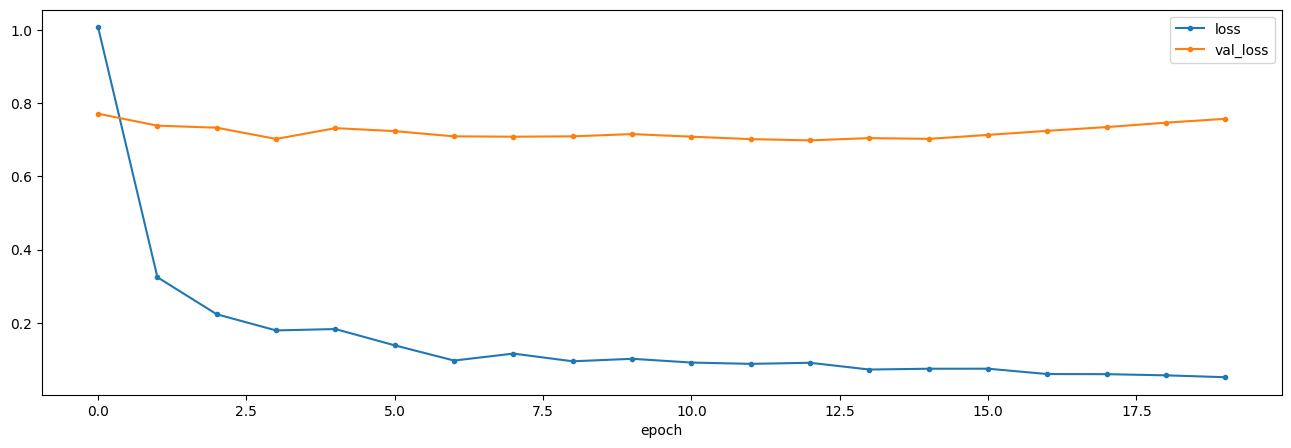

In [19]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

<h1>Denoising images using the trained model</h1>

In [20]:

from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [21]:
model_name = 'n2v_2D_stars'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


Denoising (prediction)

In [22]:
img = imread('/content/drive/MyDrive/Colab Notebooks/test4.png')
img.dtype

dtype('float32')

In [23]:

pred = model.predict(img, axes='YXC')



1/1 [==============================] - 3s 3s/step


In [24]:
pred.shape

(500, 750, 3)

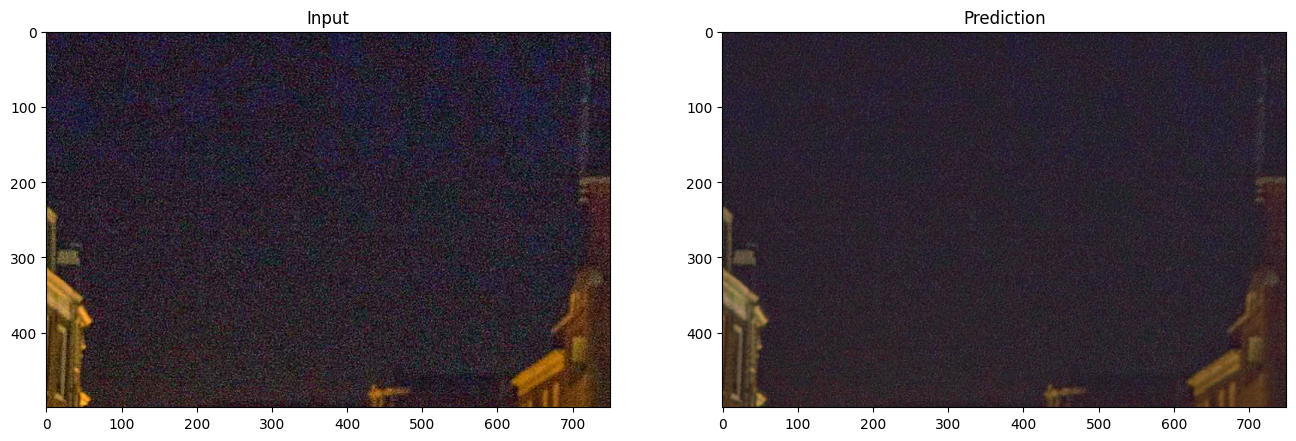

In [25]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Prediction');

In [26]:
save_tiff_imagej_compatible('pred_train.tif', pred, axes='YXC')